# TTC Headway Analysis
Mohamed Osman - 3 Feb 2020

The 'headway' is the length of time between the arrival times of two consecutive trains at a given station. Using historical TTC arrival data (Bloor-Danforth, November 2019), we can do some preliminary analyses involving that metric.

In [1]:
import pandas as pd
import pandas.io.json as pdjs
import numpy as np
import scipy.stats as sp
import sklearn
import statsmodels.api as sm
import statsmodels.graphics.correlation as smg
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import json

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)
plt.rcParams["figure.figsize"] = (10,6)

## Read in data

In [2]:
requests = pd.read_csv('requests.csv');
responses = pd.read_csv('responses.csv');

## Create initial dataset
The datasets *requests.csv* and *responses.csv* will be used for this analysis.

*requests.csv* is a dataset consisting of logs relating to the scraper interacting with TTC's API. Each request is a batch of arrival times for a station, or the next n trains to arrive at a station, with each batch being uniquely identified by a *request_id*. *request_date* is the timestamp for a request, assumed to be the exact time where the request data was retrieved by the API.

*responses.csv* includes all of the requests obtained by the scraper. Each row documents one arrival time for a train towards a station, including an assortment of qualitative and quantatative data for each one. Each row is associated with a *request_id*.

The first thing we want to do is merge *request_date* with *responses.csv* on *request_id* so we have a timestamp associated with each row.

In [23]:
# order of stations, west to east
station_order = ["KIP","ISL","RYK","OML","JNE","RUN","HPK","KEL","DNW","LAN","DUF","OSS","CHR","BAT","BSP","SGL","BAU","YNG","SHE","CFK","BRD","CHE","PAP","DON","GWD","COX","MST","VPK","WAR","KEN","NaN"]

# merge responses with request dates
# use 1mil for now, will rewrite code to include chunksize
ttc = pd.merge(responses,requests[['requestid','request_date']],on='requestid')

# remove numbers at end of station
ttc['station_char'] = ttc['station_char'].str[0:3]

# only want to look at Bloor-Danforth lines for now
ttc_init = ttc.loc[ttc['subwayline'] == 'BD']

# sort by trains left to right
ttc_init = ttc_init[ttc_init['station_char'].isin(station_order)]
ttc_init['station_char']=pd.Categorical(ttc_init['station_char'], station_order)

# sort data by estimated time, station, and request date (ascending)
ttc_init = ttc_init.sort_values(by=['station_char','request_date','timint'])

In [44]:
a = ttc_init[['station_char','trainid']].groupby('station_char').mean()
a['trainid']

station_char
KIP    222.819815
ISL    221.170097
RYK    221.138164
OML    221.698809
JNE    221.878135
RUN    221.584438
HPK    221.589491
KEL    221.699713
DNW    248.411935
LAN    248.012071
          ...    
BRD    223.878742
CHE    224.676355
PAP    224.055836
DON    224.089747
GWD    224.238817
COX    223.991200
MST    223.856677
VPK    223.400613
WAR    224.759885
KEN    227.645966
Name: trainid, Length: 30, dtype: float64

## Transform dataset

Before calculating headway, we want to transform our dataset and remove unnecessary data so that it will only have a single arrival time for a unique train reaching a station. This will be done in a few steps.

Each row in our dataset can be seen as a *recording* of a train's position at a certain moment. It includes variables such as *request_date*, *station_char*, the name of the station the train is approaching, and *timint*, the estimated time until it reaches a station. An *arrival time* in particular is the last recording of a train that is about to arrive, or just arrived at a station.

To find arrival times, we will need to do the following:



### Remove unneeded request data

Each request is comprised of up to six recordings, detailing the next three trains to arrive from both directions. We only care about the trains closest to the station, so we'll remove the rest.

In [5]:
ttc_1 = ttc_init.copy().sort_values(by=['requestid','traindirection','timint']).drop_duplicates(subset=['requestid', 'traindirection'])

In [6]:
ttc_1

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date
51,9,33583906100,BSP,BD,Normal,0.000000,East,220,AtStation,Eastbound</br> To Kennedy,2019-11-02 17:27:00.383269-04:00
57,9,33583906177,BSP,BD,Normal,0.559423,West,209,Arriving,Westbound<br/> To Kipling,2019-11-02 17:27:00.383269-04:00
63,10,33583906103,SGL,BD,Normal,0.920959,East,220,Arriving,Eastbound</br> To Kennedy,2019-11-02 17:27:00.383614-04:00
69,10,33583906174,SGL,BD,Normal,3.060400,West,211,Arriving,Westbound<br/> To Kipling,2019-11-02 17:27:00.383614-04:00
141,22,33583906109,YNG,BD,Normal,2.834621,East,220,Arriving,Eastbound</br> To Kennedy,2019-11-02 17:27:00.388161-04:00
147,22,33583906168,YNG,BD,Normal,1.119709,West,211,Arriving,Westbound<br/> To Kipling,2019-11-02 17:27:00.388161-04:00
237,39,33583906219,KIP,BD,Normal,0.000000,West,202,AtStation,Eastbound</br> To Kennedy,2019-11-02 17:27:00.394242-04:00
240,40,33583906225,ISL,BD,Normal,1.049737,East,201,Arriving,Eastbound</br> To Kennedy,2019-11-02 17:27:00.394586-04:00
241,40,33583906216,ISL,BD,Normal,3.519080,West,205,Arriving,Eastbound<br/> To Kennedy,2019-11-02 17:27:00.394586-04:00
244,41,33583906226,RYK,BD,Normal,0.000000,East,204,AtStation,Eastbound</br> To Kennedy,2019-11-02 17:27:00.394929-04:00


### Remove repeated zero-time recordings

When a train is delayed, the dataset will show multiple recordings of the train stuck at that point, all with the same *timint*. The delay data will help us out later, but the repeated recordings with *timint* being 0 is largely useless data since only the first recording can be an arrival time. So, they will need to be removed.

In [7]:
#sort such that delays are bunched together by trainid
ttc_2a = ttc_1.copy().sort_values(by=['trainid','station_char','request_date'])

# remove all rows that have the exact same 0 timint, given they're at the same station
s_tim = (ttc_2a['timint']) == (ttc_2a['timint'].shift(1,fill_value = -1))
s_stc = (ttc_2a['station_char']) == (ttc_2a['station_char'].shift(1,fill_value = "NaN"))

ttc_2 = ttc_2a.copy().loc[~((s_tim) & (s_stc) & (ttc_2a['timint'] == 0))]

In [8]:
ttc_2

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date
10957971,1932802,33635126291,KIP,BD,Normal,0.254518,East,1,Arriving,Eastbound</br> To Kennedy,2019-11-04 15:45:43.543042-05:00
11010558,1941814,33635150351,KIP,BD,Normal,0.000000,East,1,AtStation,Westbound<br/> To Kipling,2019-11-04 15:46:51.168882-05:00
10794917,1904597,33637794538,KIP,BD,Normal,1.265017,West,1,Arriving,Eastbound<br/> To Kennedy,2019-11-04 17:40:43.648100-05:00
11138089,1963968,33637818410,KIP,BD,Normal,0.254518,East,1,Arriving,Eastbound</br> To Kennedy,2019-11-04 17:41:50.660716-05:00
11005707,1941002,33637838277,KIP,BD,Normal,0.000000,East,1,AtStation,Westbound<br/> To Kipling,2019-11-04 17:42:43.548933-05:00
9634813,1704188,33852408850,KIP,BD,Normal,3.713406,West,1,Arriving,Eastbound<br/> To Kennedy,2019-11-12 18:35:43.412366-05:00
9884421,1747467,33852432450,KIP,BD,Normal,2.659773,West,1,Arriving,Eastbound<br/> To Kennedy,2019-11-12 18:36:43.592663-05:00
6456981,1141357,33880019264,KIP,BD,Normal,0.000000,East,1,AtStation,Westbound<br/> To Kipling,2019-11-13 17:56:44.084113-05:00
10714187,1890677,33635218350,ISL,BD,Normal,1.412562,East,1,Arriving,Westbound<br/> To Kipling,2019-11-04 15:49:43.708946-05:00
10795371,1904672,33635240382,ISL,BD,Normal,0.247721,East,1,Arriving,Westbound<br/> To Kipling,2019-11-04 15:50:43.830726-05:00


### Determining arrival time conditions

The goal is to clean this dataset so that we only have arrival times. One way of doing it involves sorting the current dataset by *trainid*, *station_char*, and *request_date*.

For the sake of explanation, we will define a *path* as a string of recordings where the first row is below a previous arrival time, and the last row *is* an arrival time. The data is now sorted by stations, where each station subset has a time-ordered list of paths for each train. For example, the subset for Kipling has paths to its station for train 1 for the entire month, then train 2, and so on.

In [9]:
# example: complete paths are rows 1, 2-3, 4-5, 6-9
# so the arrival times we want are 1, 3, 5, and 9
ttc_2[ttc_2['trainid'] == 214].head(10)

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date
11627062,2048767,33540541146,KIP,BD,Normal,0.000000,East,214,AtStation,Westbound<br/> To Kipling,2019-11-01 07:02:00.686311-04:00
11586531,2041625,33543068583,KIP,BD,Normal,0.862818,West,214,Arriving,Eastbound<br/> To Kennedy,2019-11-01 08:52:08.809793-04:00
11243616,1982480,33543086715,KIP,BD,Normal,0.000000,West,214,AtStation,Westbound<br/> To Kipling,2019-11-01 08:53:00.473638-04:00
11677292,2057495,33545639900,KIP,BD,Normal,0.447967,West,214,Arriving,Eastbound<br/> To Kennedy,2019-11-01 10:42:00.431601-04:00
11386242,2006969,33545664218,KIP,BD,Normal,0.000000,West,214,AtStation,Westbound<br/> To Kipling,2019-11-01 10:43:00.848139-04:00
11584314,2041255,33553203415,KIP,BD,Normal,0.254518,East,214,Arriving,Eastbound</br> To Kennedy,2019-11-01 16:09:08.383574-04:00
11379167,2005788,33553224293,KIP,BD,Normal,0.000000,East,214,AtStation,Westbound<br/> To Kipling,2019-11-01 16:10:00.746721-04:00
11451046,2018173,33558282611,KIP,BD,Normal,2.341937,West,214,Arriving,Eastbound<br/> To Kennedy,2019-11-01 19:45:00.770169-04:00
11306272,1993234,33558308614,KIP,BD,Normal,2.086937,West,214,Arriving,Eastbound<br/> To Kennedy,2019-11-01 19:46:00.394375-04:00
11356608,2001912,33558334184,KIP,BD,Normal,0.424462,West,214,Arriving,Eastbound<br/> To Kennedy,2019-11-01 19:47:00.438700-04:00


With that in mind, all we need to do is find out how to segment the paths so we can extract arrival times from them. To do that, we'll consider the following options:

**A path may be determined by *timint* monotonicly decreasing. If it increases, it might mean it's the start of a new path and that the previous row is an arrival time.** Keyword on might, though, since *timint* might increase due to delays. Also, due to incomplete data, the end of one path might have a higher *timint* than the start of another path. I relied on this condition in previous WIPs, and after considering the problems associated with it, I realized it wasn't worth my while using it. So, we'll use the following condition instead.

**If there is a significant difference in time between two rows, it might indicate a path segmentation.** Another way of looking at this is that a train cannot re-arrive at the same station within a short amount of time, and if it's any longer, it indicates the start of a new path. This will account for lapses in the data by using time as a segmentation. The problem is determining the amount of time needed for the difference to be significant. My choice was **5 minutes** since it's longer than the API call intervals (which are usually a minute), and shorter than some of the more realistic lengths of time needed for a train to arrive at the same station (for example, Warden trains can pass through and come back within 10 minutes). Unfortunately, it doesn't account for times where there's a delay and also a > 5-minute lapse in the data, but this can be mediated through other ways (like regression).

But, for now, we'll use the second rule.

In [10]:
# calculating time differences (takes long to compute!)
p1 = pd.to_datetime(ttc_2['request_date'], format = '%Y-%m-%d %H:%M:%S.%f')

In [11]:
p2 = p1.shift(-1,fill_value = 0)[:-1]
p1 = p1[:-1]
p3 = (p2-p1).astype('timedelta64[m]')

In [12]:
p3

10957971        1.0
11010558      113.0
10794917        1.0
11138089        0.0
11005707    11572.0
9634813         1.0
9884421      1400.0
6456981    -13088.0
10714187        1.0
10795371      108.0
             ...   
11716226        1.0
11556245        0.0
11481125       -4.0
11578456        0.0
11696815        0.0
11716232        1.0
11556251       -3.0
11578462        0.0
11696821        0.0
11716238       -2.0
Name: request_date, Length: 2228090, dtype: float64

In [13]:
# calculating significant differences (not between 0-5 minutes)
ttc_2['long_diff?'] = (p3 < 0) | (p3 > 5)

# keeping only relevant rows
ttc_3 = ttc_2[['trainid','station_char','timint','traindirection','train_message','long_diff?','request_date']].copy()

# getting rid of all rows with non-significant differences
ttc_3 = ttc_3[ttc_3['long_diff?'] == True]

In [14]:
ttc_3

,trainid,station_char,timint,traindirection,train_message,long_diff?,request_date
11010558,1,KIP,0.000000,East,AtStation,True,2019-11-04 15:46:51.168882-05:00
11005707,1,KIP,0.000000,East,AtStation,True,2019-11-04 17:42:43.548933-05:00
9884421,1,KIP,2.659773,West,Arriving,True,2019-11-12 18:36:43.592663-05:00
6456981,1,KIP,0.000000,East,AtStation,True,2019-11-13 17:56:44.084113-05:00
10795371,1,ISL,0.247721,East,Arriving,True,2019-11-04 15:50:43.830726-05:00
10944863,1,ISL,0.000000,West,AtStation,True,2019-11-04 17:38:51.660441-05:00
10693815,1,ISL,0.000000,East,AtStation,True,2019-11-04 17:46:43.522292-05:00
6111628,1,ISL,0.000000,West,AtStation,True,2019-11-07 16:44:51.225698-05:00
6273284,1,ISL,0.000000,East,AtStation,True,2019-11-07 17:32:43.530225-05:00
6025644,1,ISL,0.386362,West,Arriving,True,2019-11-07 19:25:44.129187-05:00


In [15]:
# example: train path for train 222
ttc_3.sort_values(by = ['trainid','request_date']).loc[ttc_3['trainid'] == 214].head(40)

,trainid,station_char,timint,traindirection,train_message,long_diff?,request_date
11200943,214,DON,0.000000,West,AtStation,True,2019-11-01 06:29:08.345688-04:00
11584891,214,PAP,0.351692,West,Arriving,True,2019-11-01 06:30:08.353167-04:00
11656467,214,CHE,0.799807,West,Arriving,True,2019-11-01 06:31:08.351715-04:00
11516673,214,BRD,0.000000,West,AtStation,True,2019-11-01 06:33:00.565449-04:00
11677857,214,CFK,0.000000,West,AtStation,True,2019-11-01 06:34:08.353537-04:00
11360363,214,SHE,0.316523,West,Arriving,True,2019-11-01 06:35:08.354096-04:00
11390707,214,YNG,0.000000,West,AtStation,True,2019-11-01 06:37:00.472357-04:00
11496263,214,BAU,0.000000,West,AtStation,True,2019-11-01 06:38:08.346451-04:00
11222188,214,SGL,0.000000,West,AtStation,True,2019-11-01 06:39:08.354461-04:00
11273414,214,BSP,0.000000,West,AtStation,True,2019-11-01 06:40:08.355152-04:00


## Calculating headway
Now that our dataset is prepared for it, we can now calculate headway.

For each row,
`headway = request_date - request_date_prev`.

Another way to compute it is
`headway = request_date + timint - request_date_prev - timint_prev`, but that may give negative headways if
`request_date + timint < request_date_prev + timint_prev`. So, for now, we'll look at the first equation. We'll also add a 24-hour clock so we can filter the data based on the time of day.

In [16]:
#note: can probably make functions out of these
ttc_4 = ttc_3.copy().drop(['long_diff?'],axis=1).sort_values(by=["station_char","request_date"]).loc[ttc_3['station_char'] == ttc_3['station_char'].shift(-1,fill_value = "NaN")]

#add 24h clocks
ttc_4['rq_24h'] = pd.to_datetime(ttc_4['request_date'], format = '%Y-%m-%d %H:%M:%S.%f', utc=True).dt.strftime('%H:%M:%S')

# eastbound trains (WAR -> KIP)
ttc_east = ttc_4.copy().loc[((ttc_4['traindirection'] == 'East') | (ttc_4['station_char'] == 'KEN')) & ~(ttc_4['station_char'] == 'KIP')]
ttc_east['request_date_prev'] = ttc_east.request_date.shift(1,fill_value = "NaN")
ttc_east = ttc_east[1:]

# westbound trains (KEN->ISL)
ttc_west = ttc_4.copy().loc[((ttc_4['traindirection'] == 'West') | (ttc_4['station_char'] == 'KIP')) & ~(ttc_4['station_char'] == 'KEN')]
ttc_west['request_date_prev'] = ttc_west.request_date.shift(1,fill_value = "NaN")
ttc_west = ttc_west[1:]

In [17]:
ttc_east

,trainid,station_char,timint,traindirection,train_message,request_date,rq_24h,request_date_prev
11513034,228,ISL,0.000000,East,AtStation,2019-11-01 05:49:00.389950-04:00,09:49:00,2019-11-01 05:43:00.358469-04:00
11340984,230,ISL,0.483770,East,Arriving,2019-11-01 05:54:07.349620-04:00,09:54:07,2019-11-01 05:49:00.389950-04:00
11565834,232,ISL,0.000000,East,AtStation,2019-11-01 06:01:00.531585-04:00,10:01:00,2019-11-01 05:54:07.349620-04:00
11344208,234,ISL,0.483770,East,Arriving,2019-11-01 06:04:00.262129-04:00,10:04:00,2019-11-01 06:01:00.531585-04:00
11717160,236,ISL,0.000000,East,AtStation,2019-11-01 06:09:08.363434-04:00,10:09:08,2019-11-01 06:04:00.262129-04:00
11271090,238,ISL,0.249309,East,Arriving,2019-11-01 06:14:08.356605-04:00,10:14:08,2019-11-01 06:09:08.363434-04:00
11709417,240,ISL,0.000000,East,AtStation,2019-11-01 06:19:07.351073-04:00,10:19:07,2019-11-01 06:14:08.356605-04:00
11298736,242,ISL,0.483770,East,Arriving,2019-11-01 06:23:00.812229-04:00,10:23:00,2019-11-01 06:19:07.351073-04:00
11622187,245,ISL,0.000000,East,AtStation,2019-11-01 06:28:00.451086-04:00,10:28:00,2019-11-01 06:23:00.812229-04:00
11570046,247,ISL,0.483770,East,Arriving,2019-11-01 06:32:00.462490-04:00,10:32:00,2019-11-01 06:28:00.451086-04:00


In [18]:
# get rid of unneeded categories for each dataset
ttc_east['station_char'] = ttc_east['station_char'].cat.remove_unused_categories()
ttc_west['station_char'] = ttc_west['station_char'].cat.remove_unused_categories()

In [19]:
#headways
he = pd.to_datetime(ttc_east['request_date']) - pd.to_datetime(ttc_east['request_date_prev'])
hw = pd.to_datetime(ttc_west['request_date']) - pd.to_datetime(ttc_west['request_date_prev'])

ttc_east['headway'] = (he.astype('timedelta64[s]')/60).round(2)
ttc_west['headway'] = (hw.astype('timedelta64[s]')/60).round(2)

In [20]:
# remove headways == 0 (look into this)
ttc_east = ttc_east[ttc_east['headway'] != 0]
ttc_west = ttc_west[ttc_west['headway'] != 0]

# cut headways longer than two hours
max_headway = 120; # 2 hours

ttc_east = ttc_east.loc[(ttc_east['headway'] < max_headway) & (ttc_east['headway'] >= 0)]
ttc_west = ttc_west.loc[(ttc_west['headway'] < max_headway) & (ttc_west['headway'] >= 0)]

In [21]:
# cut times before 6AM and after 1AM

start_clock = '06:00:00'
end_clock = '01:00:00'

pde = pd.to_datetime(ttc_east['rq_24h'],format='%H:%M:%S')
pdw = pd.to_datetime(ttc_west['rq_24h'],format='%H:%M:%S')

ttc_east = ttc_east.loc[~((pde > pd.to_datetime(end_clock,format='%H:%M:%S')) & (pde < pd.to_datetime(start_clock,format='%H:%M:%S')))]
ttc_west = ttc_west.loc[~((pdw > pd.to_datetime(end_clock,format='%H:%M:%S')) & (pdw < pd.to_datetime(start_clock,format='%H:%M:%S')))]

In [22]:
ttc_east

,trainid,station_char,timint,traindirection,train_message,request_date,rq_24h,request_date_prev,headway
11513034,228,ISL,0.000000,East,AtStation,2019-11-01 05:49:00.389950-04:00,09:49:00,2019-11-01 05:43:00.358469-04:00,6.00
11340984,230,ISL,0.483770,East,Arriving,2019-11-01 05:54:07.349620-04:00,09:54:07,2019-11-01 05:49:00.389950-04:00,5.10
11565834,232,ISL,0.000000,East,AtStation,2019-11-01 06:01:00.531585-04:00,10:01:00,2019-11-01 05:54:07.349620-04:00,6.88
11344208,234,ISL,0.483770,East,Arriving,2019-11-01 06:04:00.262129-04:00,10:04:00,2019-11-01 06:01:00.531585-04:00,2.98
11717160,236,ISL,0.000000,East,AtStation,2019-11-01 06:09:08.363434-04:00,10:09:08,2019-11-01 06:04:00.262129-04:00,5.13
11271090,238,ISL,0.249309,East,Arriving,2019-11-01 06:14:08.356605-04:00,10:14:08,2019-11-01 06:09:08.363434-04:00,4.98
11709417,240,ISL,0.000000,East,AtStation,2019-11-01 06:19:07.351073-04:00,10:19:07,2019-11-01 06:14:08.356605-04:00,4.97
11298736,242,ISL,0.483770,East,Arriving,2019-11-01 06:23:00.812229-04:00,10:23:00,2019-11-01 06:19:07.351073-04:00,3.88
11622187,245,ISL,0.000000,East,AtStation,2019-11-01 06:28:00.451086-04:00,10:28:00,2019-11-01 06:23:00.812229-04:00,4.98
11570046,247,ISL,0.483770,East,Arriving,2019-11-01 06:32:00.462490-04:00,10:32:00,2019-11-01 06:28:00.451086-04:00,4.00


## Summary Statistics

Now that we calculated headway, let's display some useful statistics.

### Boxplot
The code below plots the distribution of headway for each station in the form of boxplots.

Text(0, 0.5, 'Headway (minutes)')

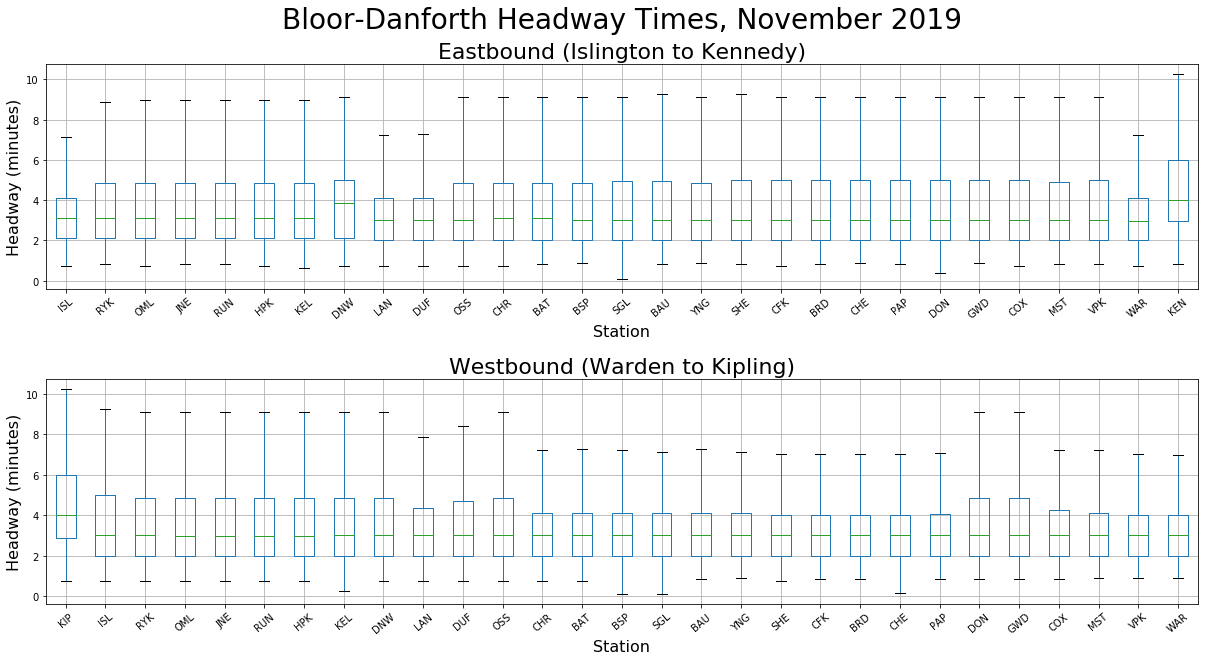

In [23]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(20,10))

ttc_east.boxplot(column = 'headway', by = 'station_char', rot=40, ax = axes[0], showfliers=False)
ttc_west.boxplot(column = 'headway', by = 'station_char', rot=40, ax = axes[1], showfliers=False)

fig.suptitle('Bloor-Danforth Headway Times, November 2019', fontsize=28)
fig.subplots_adjust(hspace = 0.4)

axes[0].set_title('Eastbound (Islington to Kennedy)', fontsize=22)
axes[0].set_xlabel('Station', fontsize=16)
axes[0].set_ylabel("Headway (minutes)",fontsize=16)

axes[1].set_title('Westbound (Warden to Kipling)', fontsize=22)
axes[1].set_xlabel('Station', fontsize=16)
axes[1].set_ylabel("Headway (minutes)",fontsize=16)

All of them appear to have right-skewed distributions, which might imply that the headways aren't normally distributed. QQ-plots can make this more clear.

### Normal QQ-plots

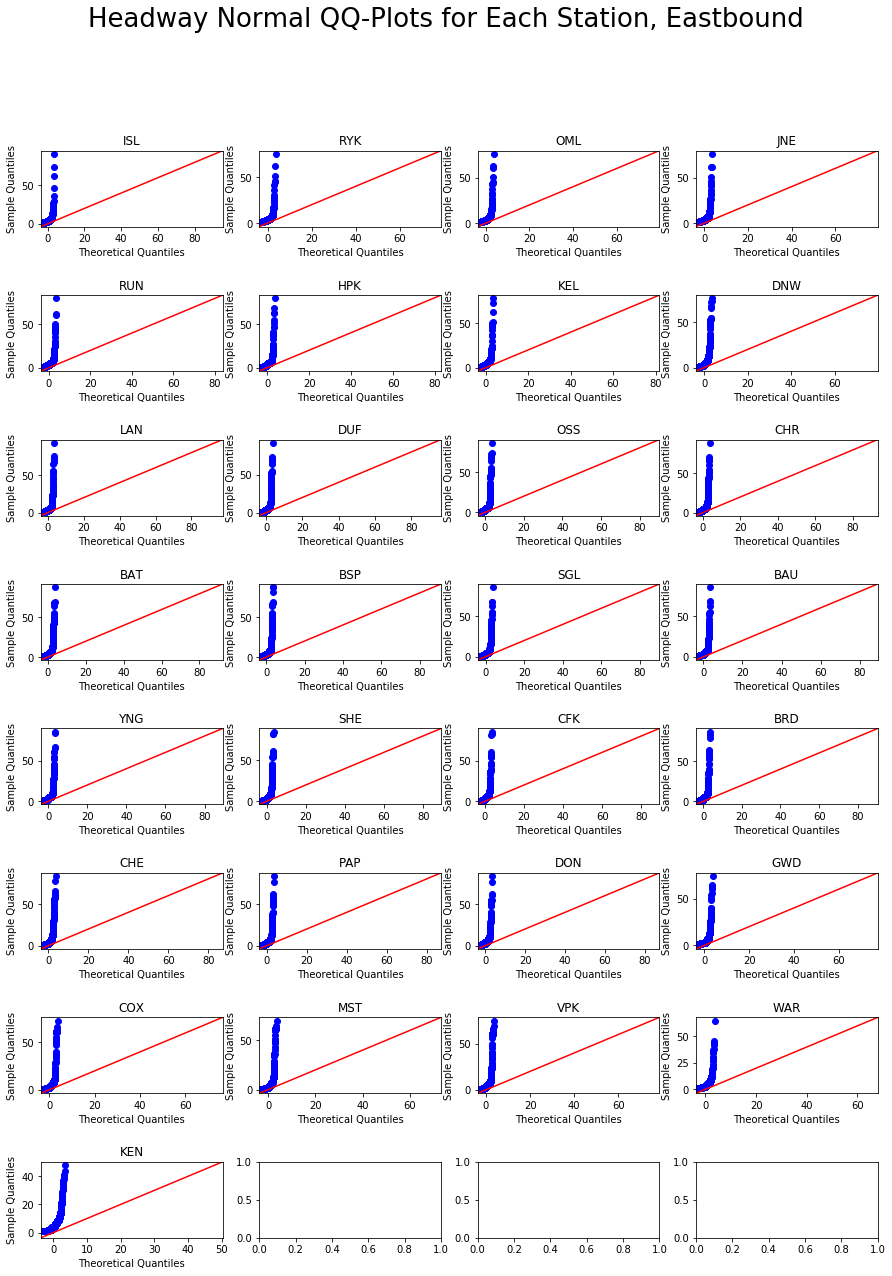

In [24]:
def displayGroupQQPlots(dataset, fig_title, subset, groupby_key, col):
    ds = dataset[subset].groupby(groupby_key)
    nr = np.ceil(len(ds)/4)
    fig, axes = plt.subplots(nrows = int(nr), ncols = 4, figsize=(15,20))
    fig.subplots_adjust(hspace = 0.9)
    fig.suptitle(fig_title, fontsize=26)
    a = 0
    b = 0
    for g in ds.groups:
        dg = dataset[dataset[groupby_key] == g]
        axes[b,a].set_title(g)
        sm.qqplot(dg[col],ax = axes[b,a], line='45')
        a+=1
        if (a >= 4):
            a = 0
            b += 1

displayGroupQQPlots(ttc_east,'Headway Normal QQ-Plots for Each Station, Eastbound',
                    ['station_char','headway'],'station_char','headway')

The graphs are heavily skewed by the sample quantiles, meaning their distributions are definitely not normal. 

### Mean bar plot

Text(0, 0.5, 'Headway (minutes)')

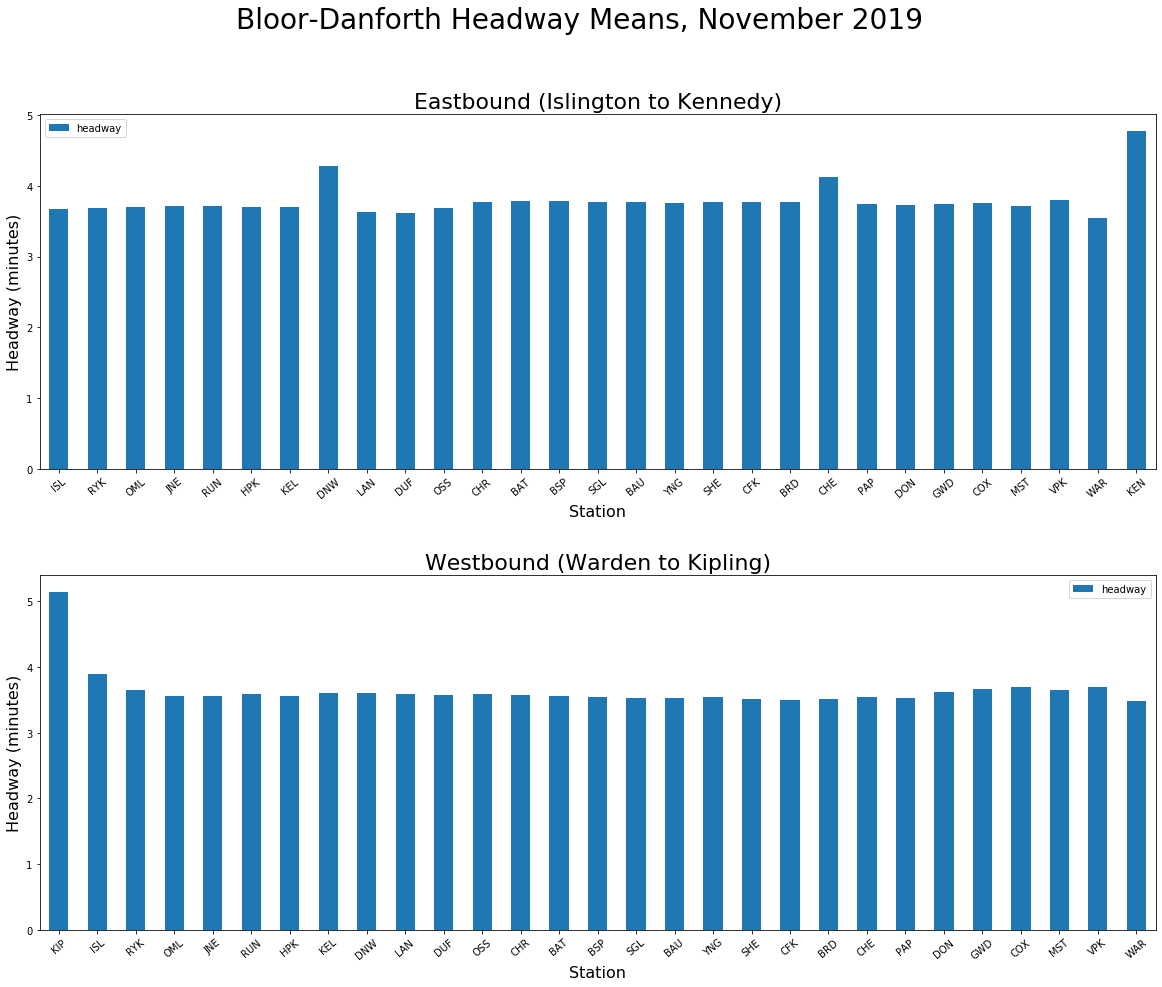

In [25]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(20,15))
ttc_east[['station_char','headway']].groupby('station_char').mean().plot(kind='bar', ax = axes[0], rot=40)
ttc_west[['station_char','headway']].groupby('station_char').mean().plot(kind='bar', ax = axes[1], rot=40)

fig.suptitle('Bloor-Danforth Headway Means, November 2019', fontsize=28)
fig.subplots_adjust(hspace = 0.3)

axes[0].set_title('Eastbound (Islington to Kennedy)', fontsize=22)
axes[0].set_xlabel('Station', fontsize=16)
axes[0].set_ylabel("Headway (minutes)",fontsize=16)

axes[1].set_title('Westbound (Warden to Kipling)', fontsize=22)
axes[1].set_xlabel('Station', fontsize=16)
axes[1].set_ylabel("Headway (minutes)",fontsize=16)

Looks like the mean headways for most of the stations are just below four minutes. The means for the corner stations, Kipling and Kennedy, are a lot higher, which I'm assuming because they can hold two trains at once.

### Descriptive statistics

In [26]:
# eastbound
ttc_east[['station_char','headway']].groupby('station_char').describe()

headway                                                   
               count      mean       std   min   25%   50%   75%    max
station_char                                                           
ISL           7353.0  3.670287  2.419681  0.73  2.12  3.12  4.13  90.87
RYK           7408.0  3.685599  2.405574  0.85  2.12  3.10  4.85  74.98
OML           7398.0  3.707310  2.669448  0.72  2.12  3.12  4.87  75.87
JNE           7373.0  3.717587  2.630411  0.85  2.12  3.12  4.87  75.73
RUN           7401.0  3.721312  2.718762  0.85  2.12  3.12  4.87  79.87
HPK           7419.0  3.706277  2.793859  0.73  2.12  3.12  4.87  78.98
KEL           7418.0  3.696437  2.695176  0.62  2.12  3.12  4.87  77.98
DNW           6462.0  4.277377  3.924659  0.73  2.13  3.87  5.00  75.98
LAN           7645.0  3.631902  3.440168  0.73  2.00  3.00  4.13  92.87
DUF           7668.0  3.615472  3.404213  0.75  2.00  3.00  4.12  91.98
...              ...       ...       ...   ...   ...   ...   ...    ...
BRD           7369.0  3.777143  3.538556  0.85  2.00  3.00  4.98  86.12
CHE           6812.0  4.125097  4.160423  0.87  2.00  3.00  4.98  83.12
PAP           7481.0  3.740430  3.442129  0.85  2.00  3.00  4.98  83.12
DON           7489.0  3.727110  3.387840  0.37  2.00  3.00  4.98  83.12
GWD           7532.0  3.744126  3.171858  0.87  2.00  3.00  4.98  73.87
COX           7725.0  3.761995  3.670688  0.73  2.00  3.00  4.98  72.98
MST           7889.0  3.716764  4.051838  0.85  2.00  3.00  4.88  69.87
VPK           7773.0  3.793477  4.193349  0.85  2.00  3.00  4.98  74.87
WAR           7424.0  3.545374  2.614360  0.75  2.00  2.98  4.12  64.87
KEN           5487.0  4.769965  3.487706  0.85  2.97  4.00  6.00  47.98

[29 rows x 8 columns]

In [27]:
# westbound
ttc_west[['station_char','headway']].groupby('station_char').describe()

headway                                                    
               count      mean       std   min   25%   50%    75%    max
station_char                                                            
KIP           5920.0  5.139348  5.803780  0.73  2.87  4.00  6.000  76.98
ISL           7222.0  3.889111  3.484563  0.73  2.00  3.00  4.980  72.98
RYK           7728.0  3.647334  3.143972  0.72  2.00  3.00  4.870  70.98
OML           7873.0  3.558485  2.889793  0.72  1.98  2.98  4.870  68.98
JNE           7909.0  3.555036  3.073624  0.73  1.98  2.98  4.870  67.98
RUN           7838.0  3.588122  3.217393  0.72  2.00  2.98  4.870  78.80
HPK           7896.0  3.563105  3.154439  0.73  2.00  2.98  4.850  78.72
KEL           7801.0  3.602548  3.312826  0.27  1.98  3.00  4.870  78.83
DNW           7709.0  3.601769  3.092303  0.73  2.00  3.00  4.870  75.83
LAN           7758.0  3.586311  3.063843  0.73  2.00  3.00  4.365  64.98
...              ...       ...       ...   ...   ...   ...    ...    ...
CFK           7823.0  3.495678  2.682171  0.85  2.00  3.00  4.020  67.87
BRD           7793.0  3.511400  2.766026  0.85  2.00  3.00  4.020  64.87
CHE           7746.0  3.537338  2.956112  0.15  2.00  3.00  4.020  86.00
PAP           7774.0  3.526186  2.846333  0.85  2.00  3.00  4.045  68.98
DON           7505.0  3.623288  2.805870  0.85  2.00  3.00  4.870  64.98
GWD           7332.0  3.665877  2.792217  0.85  2.00  3.00  4.870  65.87
COX           7337.0  3.693533  3.075055  0.85  2.00  3.00  4.250  86.88
MST           7284.0  3.650748  2.666908  0.87  2.00  3.00  4.105  76.98
VPK           7132.0  3.701179  2.815512  0.87  2.00  3.00  4.020  65.87
WAR           7049.0  3.488278  1.797947  0.87  2.00  3.00  4.000  68.87

[29 rows x 8 columns]

## Prediction
While we have what we need to report daily summary statistics on the performance of subway trains, it would be nice to see if we can predict headway based on certain factors featured in the dataset or elsewhere. We will attempt to do so by using regression.

### Weather
Transit can be affected by weather, so it would be interesting to see how it affects train arrivals. Environment Canada provides historical monthly datasets on Toronto's weather, which is what we will use for our regression model.

#### Web Scraping
Originally, to acquire weather data, I scraped Environment Canada's live weather feed on a daily basis. node.js was used for the scraping code, and AWS/Serverless was used to automate the daily scraping process. The code below takes one of the days that were scraped (written in JSON) and converts it into a pandas dataframe.

In [28]:
# source: https://stackoverflow.com/questions/53699012/performant-cartesian-product-cross-join-with-pandas
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

# note: listingId lists the date the data was scrapped, but the actual scrapped data is from a day before
# ex: listingId date is 6 Jan, but the data is for 5 Jan
with open('weather24h.json') as w:
    weather_aws = json.load(w)

wa1 = pdjs.json_normalize(weather_aws)

weather_data = pdjs.json_normalize(wa1['weather'].iloc[0])
listing_id = pd.DataFrame(wa1['listingId'])

cartesian_product_basic(weather_data[weather_data['temp'] != 'NA'],listing_id).drop_duplicates(subset=['time'])

,conditions,temp,time,wind_chill,listingId
0,Light Snow,-1,23:00,-7,Mon Jan 06 2020 04:36:23 GMT+0000 (Coordinated...
1,Light Snow,-1,22:00,-7,Mon Jan 06 2020 04:36:23 GMT+0000 (Coordinated...
2,Light Snow,-1,21:00,-8,Mon Jan 06 2020 04:36:23 GMT+0000 (Coordinated...
3,Light Snow,-1,20:00,-7,Mon Jan 06 2020 04:36:23 GMT+0000 (Coordinated...
4,Light Snow,-1,19:00,-6,Mon Jan 06 2020 04:36:23 GMT+0000 (Coordinated...
5,Light Snow,0,18:00,-5,Mon Jan 06 2020 04:36:23 GMT+0000 (Coordinated...
6,Mostly Cloudy,1,17:00,NA,Mon Jan 06 2020 04:36:23 GMT+0000 (Coordinated...
7,Mostly Cloudy,1,16:00,NA,Mon Jan 06 2020 04:36:23 GMT+0000 (Coordinated...
8,Mostly Cloudy,1,15:00,NA,Mon Jan 06 2020 04:36:23 GMT+0000 (Coordinated...
9,Mostly Cloudy,1,14:00,NA,Mon Jan 06 2020 04:36:23 GMT+0000 (Coordinated...


Now here is the actual weather dataset that will be used for the model.

In [29]:
# incorporate weather data from Environment Canada
weather = pd.read_csv('weather.csv')
weather.head(10)

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),Rel Hum Flag,Wind Dir (10s deg),Wind Dir Flag,Wind Spd (km/h),Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-79.63,43.68,TORONTO INTL A,6158731,2019-11-01 00:00,2019,11,1,00:00,5.8,NaN,3.7,NaN,87,NaN,24,NaN,41,NaN,24.1,NaN,97.46,NaN,NaN,NaN,NaN,NaN,Rain Showers
1,-79.63,43.68,TORONTO INTL A,6158731,2019-11-01 01:00,2019,11,1,01:00,4.0,NaN,0.1,NaN,76,NaN,27,NaN,46,NaN,24.1,NaN,97.78,NaN,NaN,NaN,NaN,NaN,Rain Showers
2,-79.63,43.68,TORONTO INTL A,6158731,2019-11-01 02:00,2019,11,1,02:00,3.2,NaN,0.0,NaN,79,NaN,27,NaN,37,NaN,16.1,NaN,98.10,NaN,NaN,NaN,NaN,NaN,"Rain,Snow"
3,-79.63,43.68,TORONTO INTL A,6158731,2019-11-01 03:00,2019,11,1,03:00,2.8,NaN,0.5,NaN,85,NaN,28,NaN,37,NaN,24.1,NaN,98.30,NaN,NaN,NaN,NaN,NaN,"Rain,Snow"
4,-79.63,43.68,TORONTO INTL A,6158731,2019-11-01 04:00,2019,11,1,04:00,2.6,NaN,0.1,NaN,84,NaN,27,NaN,38,NaN,24.1,NaN,98.55,NaN,NaN,NaN,NaN,NaN,"Rain Showers,Snow"
5,-79.63,43.68,TORONTO INTL A,6158731,2019-11-01 05:00,2019,11,1,05:00,2.6,NaN,-0.8,NaN,78,NaN,27,NaN,38,NaN,24.1,NaN,98.79,NaN,NaN,NaN,NaN,NaN,NaN
6,-79.63,43.68,TORONTO INTL A,6158731,2019-11-01 06:00,2019,11,1,06:00,2.8,NaN,-1.9,NaN,71,NaN,28,NaN,41,NaN,24.1,NaN,99.03,NaN,NaN,NaN,NaN,NaN,NaN
7,-79.63,43.68,TORONTO INTL A,6158731,2019-11-01 07:00,2019,11,1,07:00,2.7,NaN,-2.9,NaN,67,NaN,27,NaN,37,NaN,24.1,NaN,99.24,NaN,NaN,NaN,NaN,NaN,Mostly Cloudy
8,-79.63,43.68,TORONTO INTL A,6158731,2019-11-01 08:00,2019,11,1,08:00,2.9,NaN,-3.3,NaN,64,NaN,26,NaN,31,NaN,24.1,NaN,99.45,NaN,NaN,NaN,NaN,NaN,NaN
9,-79.63,43.68,TORONTO INTL A,6158731,2019-11-01 09:00,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# create weather key to join weather and ttc data
ttc_east['Date/Time'] = pd.to_datetime(ttc_east['request_date'], format = '%Y-%m-%d %H:%M:%S.%f', utc = True).dt.floor('1h').dt.strftime('%Y-%m-%d %H:%M')

ttc_east_w = pd.merge(ttc_east,weather)
ttc_east_w.head(10)

,trainid,station_char,timint,traindirection,train_message,request_date,rq_24h,request_date_prev,headway,Date/Time,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),Rel Hum Flag,Wind Dir (10s deg),Wind Dir Flag,Wind Spd (km/h),Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,228,ISL,0.000000,East,AtStation,2019-11-01 05:49:00.389950-04:00,09:49:00,2019-11-01 05:43:00.358469-04:00,6.00,2019-11-01 09:00,-79.63,43.68,TORONTO INTL A,6158731,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN
1,230,ISL,0.483770,East,Arriving,2019-11-01 05:54:07.349620-04:00,09:54:07,2019-11-01 05:49:00.389950-04:00,5.10,2019-11-01 09:00,-79.63,43.68,TORONTO INTL A,6158731,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN
2,228,RYK,0.000000,East,AtStation,2019-11-01 05:51:00.481329-04:00,09:51:00,2019-11-01 05:45:00.769362-04:00,5.98,2019-11-01 09:00,-79.63,43.68,TORONTO INTL A,6158731,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN
3,230,RYK,0.645449,East,Arriving,2019-11-01 05:56:00.612406-04:00,09:56:00,2019-11-01 05:51:00.481329-04:00,5.00,2019-11-01 09:00,-79.63,43.68,TORONTO INTL A,6158731,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN
4,228,OML,0.000000,East,AtStation,2019-11-01 05:53:00.450297-04:00,09:53:00,2019-11-01 05:47:00.340878-04:00,6.00,2019-11-01 09:00,-79.63,43.68,TORONTO INTL A,6158731,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN
5,230,OML,0.270217,East,Arriving,2019-11-01 05:58:00.326867-04:00,09:58:00,2019-11-01 05:53:00.450297-04:00,4.98,2019-11-01 09:00,-79.63,43.68,TORONTO INTL A,6158731,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN
6,228,JNE,0.000000,East,AtStation,2019-11-01 05:54:07.348475-04:00,09:54:07,2019-11-01 05:49:00.390977-04:00,5.10,2019-11-01 09:00,-79.63,43.68,TORONTO INTL A,6158731,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN
7,228,RUN,0.000000,East,AtStation,2019-11-01 05:56:00.621981-04:00,09:56:00,2019-11-01 05:50:00.371499-04:00,6.00,2019-11-01 09:00,-79.63,43.68,TORONTO INTL A,6158731,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN
8,228,HPK,1.021082,East,Arriving,2019-11-01 05:56:00.622355-04:00,09:56:00,2019-11-01 05:52:08.358826-04:00,3.87,2019-11-01 09:00,-79.63,43.68,TORONTO INTL A,6158731,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN
9,228,KEL,0.715987,East,Arriving,2019-11-01 05:58:00.328238-04:00,09:58:00,2019-11-01 05:53:00.451656-04:00,4.98,2019-11-01 09:00,-79.63,43.68,TORONTO INTL A,6158731,2019,11,1,09:00,3.3,NaN,-3.7,NaN,60,NaN,27,NaN,30,NaN,24.1,NaN,99.62,NaN,NaN,NaN,NaN,NaN,NaN


### Regression

Now we will make our regression model appropriate for our response variable, headway.

Headway isn't normally distributed for any of the stations, so linear regression isn't appropriate. But the variable can be interpreted as discrete, positive integer count data when rounded or converted into seconds (we'll choose the former). It has no known max, so Poisson regression might be useful for it, and if there's overdispersion, then Negative Binomial regression can take its place.

I tried out both models to assess their performance. Deviance tests will be used to assess their goodness of fit, and k-fold cross-validation will assess how they generalize with unseen data. With cross-validation, the trained model will be "accurate" if the model prediction `model_pred` is within one minute of the actual test values `y_test`.

In [31]:
# functions

# Null model comparison, "model explains x% of the deviance beyond the null model"
def null_comp(fit):
    return 1-fit.deviance/fit.null_deviance

def to_percent(x):
    return np.round(x*100,1)

# Check for Poisson mean = variance assumption by calculating dispersion
# Overdispersion (variance > mean) if phi > 1
# Underdispersio (variance < mean) if phi < 1

def dispersion(fit,X,y):
    mu_hat = (fit.predict())
    var_hat = np.power(y-mu_hat,2)
    n = X.shape[0]
    p = fit.params.shape[0]
    return np.sum(var_hat/mu_hat)/(n-p)

def dispersion2(fit,mu_hat,y):
    var_hat = np.power(y-mu_hat,2)
    n = y.shape[0]
    p = fit.params.shape[0]
    return np.sum(var_hat/mu_hat)/(n-p)

#abline source: https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def dispersion_graph(fit,X,y):
    mu_hat = (fit.predict())
    var_hat = np.power(y-mu_hat,2)
    fig, ax = plt.subplots()
    ax.scatter(np.log(mu_hat), np.log(var_hat))
    abline(1,0)

def dispersion_graph2(fit,mu_hat,y):
    var_hat = np.power(y-mu_hat,2)
    fig, ax = plt.subplots()
    ax.scatter(np.log(mu_hat), np.log(var_hat))
    abline(1,0)
    
# Rule of thumb goodness of fit
# if (deviance/(n-p)) >> 1, model is not an adequate fit
# source: Introduction to Linear Regression Analysis (Montgomery, Peck, Vining, 5E), page 432
def dev_gof(fit,X):
    n = X.shape[0]
    p = fit.params.shape[0]
    return fit.deviance/(n-p)

In [68]:
def ttc_model_tests(ds, k, family, formula):
    # 1: pre-prcoess
    # remove unused categories
    ds['station_char'] = ds['station_char'].cat.remove_unused_categories()
    
    # convert time into circular continous variables
    ds['rq_24h'] = ds['rq_24h'].str[0:2]
    ds['xhr'] = np.sin(2*np.pi*ds['rq_24h'].astype(int)/24)
    ds['yhr'] = np.cos(2*np.pi*ds['rq_24h'].astype(int)/24)
    
    # subset dataset
    ds = ds[['headway','xhr','yhr','station_char','train_message','Temp (°C)',
              'Visibility (km)','Stn Press (kPa)', 'Wind Spd (km/h)']]
    
    # remove the last (up to) k rows to make ds divisible by k
    dsk = ds.shape[0] % k
    if (dsk > 0):
        ds = ds.iloc[:-dsk]
    
    # ceil headway to the nearest minute
    ds['headway'] = np.ceil(ds['headway'])
    
    # rename variables
    ds = pd.get_dummies(data=ds,drop_first = True).rename(columns=
            {'Temp (°C)':'temp','train_message_AtStation':'tm_station','train_message_Delayed':"tm_delayed",
            'Visibility (km)':'vis','Stn Press (kPa)':'st_press', 'Wind Spd (km/h)':'w_spd'})
    # 1: k-fold CV
    # shuffle dataset and cut it into k indices
    ds_list = np.split(ds.sample(frac=1), k, axis=0)
    
    accuracy = 0
    acc_range = 1
    
    # for each k,
    for i in range(k):
        dl = ds_list.copy()
        test = dl.pop(i)
        x_test = test.drop('headway', axis=1)
        y_test = test['headway']
        train = pd.concat(dl)
        model = smf.glm(formula=formula, data = train, family = family).fit()
        model_pred = model.predict(x_test)
        acc = sum((y_test - acc_range/2 <= model_pred) & (model_pred <= y_test + acc_range/2))/model_pred.shape[0]
        accuracy += acc
        mse = (y_test-model_pred)-acc_range
        mse[mse < 0] = 0
        mse = np.sum(np.power(mse,2))/model_pred.shape[0]
        print('k = ' + str(i+1) + ", accuracy within " + str(acc_range) + " minute")
        print('Accuracy: ' + str(np.round(acc*100,1))+str('%'))
        print('Model explains ' + str(to_percent(null_comp(model))) + '% of the deviance beyond the null model')
        print('---------------------------------------')
    accuracy = np.round((accuracy/k)*1000)/10
    print("Mean accuracy: " + str(accuracy) + "%")
    print('---------------------------------------')
    print('Full model:')
    m_all = smf.glm(formula=formula, data = ds, family = family).fit()
    print(m_all.summary())
    print('Full model explains ' + str(to_percent(null_comp(m_all))) + '% of the deviance beyond the null model') 
    print('Dispersion: ' + str(dispersion(m_all,ds,ds['headway'])))
    print('Deviance goodness-of-fit (>> 1 = bad): ' + str(np.round(dev_gof(m_all,ds),2)))
    dispersion_graph(m_all,ds,ds['headway'])

### Model 1: Poisson Regression

k = 1, accuracy within 1 minute
Accuracy: 17.1%
Model explains 10.4% of the deviance beyond the null model
---------------------------------------
k = 2, accuracy within 1 minute
Accuracy: 16.5%
Model explains 10.6% of the deviance beyond the null model
---------------------------------------
k = 3, accuracy within 1 minute
Accuracy: 17.0%
Model explains 11.3% of the deviance beyond the null model
---------------------------------------
k = 4, accuracy within 1 minute
Accuracy: 15.3%
Model explains 10.6% of the deviance beyond the null model
---------------------------------------
k = 5, accuracy within 1 minute
Accuracy: 18.5%
Model explains 9.5% of the deviance beyond the null model
---------------------------------------
k = 6, accuracy within 1 minute
Accuracy: 18.2%
Model explains 10.3% of the deviance beyond the null model
---------------------------------------
k = 7, accuracy within 1 minute
Accuracy: 17.1%
Model explains 10.5% of the deviance beyond the null model
------------

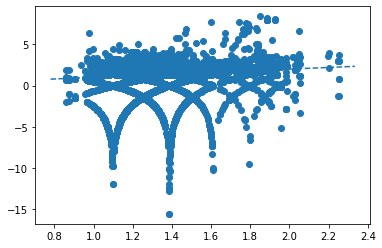

In [70]:
# todo: run for all stations and directions
ttc_model_tests(ttc_east_w[ttc_east_w['station_char'] == "COX"], 10, sm.families.Poisson(),
                'headway ~ xhr*yhr*temp + temp*tm_station + w_spd*tm_station + w_spd*st_press + temp*st_press + w_spd*temp + xhr*yhr*w_spd')

### Model 2: Negative Binomial Regression

k = 1, accuracy within 1 minute
Accuracy: 16.5%
Model explains 11.0% of the deviance beyond the null model
---------------------------------------
k = 2, accuracy within 1 minute
Accuracy: 13.9%
Model explains 11.4% of the deviance beyond the null model
---------------------------------------
k = 3, accuracy within 1 minute
Accuracy: 16.6%
Model explains 11.4% of the deviance beyond the null model
---------------------------------------
k = 4, accuracy within 1 minute
Accuracy: 15.8%
Model explains 11.7% of the deviance beyond the null model
---------------------------------------
k = 5, accuracy within 1 minute
Accuracy: 17.9%
Model explains 11.1% of the deviance beyond the null model
---------------------------------------
k = 6, accuracy within 1 minute
Accuracy: 16.5%
Model explains 10.4% of the deviance beyond the null model
---------------------------------------
k = 7, accuracy within 1 minute
Accuracy: 18.2%
Model explains 10.4% of the deviance beyond the null model
-----------

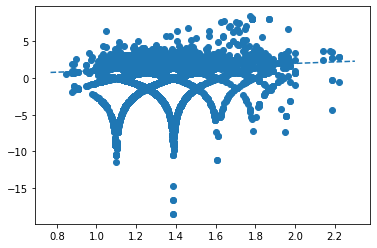

In [71]:
# todo: run for all stations and directions
ttc_model_tests(ttc_east_w[ttc_east_w['station_char'] == "COX"], 10, sm.families.NegativeBinomial(),
                'headway ~ xhr*yhr*temp + temp*tm_station + w_spd*tm_station + w_spd*st_press + temp*st_press + w_spd*temp + xhr*yhr*w_spd')

## Conclusion
This report showed a way of calculating headway given TTC data, and provided some insight into how some factors might affect it in a regression model.

Headways for each station seem to have an average of approximately 4 minutes, which is the standard proposed by the TTC. On the regression side, a Negative Binomial model seems to be the most appropriate for headway prediction due to overdispersed count data, but a more robust model is required to have better prediction rates.

In [74]:
ttc_east.to_csv('ttc_east.csv')

In [78]:
ttc_east.groupby('station_char').groups

{'ISL': Int64Index([11513034, 11340984, 11565834, 11344208, 11717160, 11271090,
             11709417, 11298736, 11622187, 11570046,
             ...
              6935295,  6984963,  7342587,  7056677,  6964923,  6953391,
              6951178,  7283831,  7256385,  7273704],
            dtype='int64', length=7353),
 'RYK': Int64Index([11184345, 11472627, 11313185, 11242996, 11557906, 11208266,
             11487354, 11177324, 11584763, 11677742,
             ...
              7211478,  7182420,  7346623,  7215251,  7248045,  6971148,
              7363713,  7273706,  7110974,  7015668],
            dtype='int64', length=7408),
 'OML': Int64Index([11579658, 11706769, 11344216, 11381381, 11372478, 11715678,
             11298744, 11597928, 11570054, 11642299,
             ...
              7342595,  6945762,  7219608,  7206696,  6982766,  6938170,
              7214905,  7108088,  7131895,  6919362],
            dtype='int64', length=7398),
 'JNE': Int64Index([11340996, 11222547, 115231